In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet
import torchvision.models as models


os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# 最終層を4クラスの出力に変更
model.fc = nn.Linear(num_ftrs, 4)

# Set all layers to trainable
for param in model.parameters():
    param.requires_grad = True  # Set to True for fine-tuning
model = model.to(device)

print(model)

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
#データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/train')  #学習用データ：データ数は560
test_dataset  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/test') 

transform = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [4]:
from torchsummary import summary

summary(model, (3,224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [5]:
# Train
def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingの設定
    the_last_loss = 100  
    patience = 10
    trigger_times = 0

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        for data,target in  cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted==labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1 

        print('epoch:%d loss: %.3f acc: %.3f' %
             (epoch + 1, running_loss / batch_count, correct_num*100/total_num))
            

        # Early stopping
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss

    return model

In [6]:
#validation

def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for data,target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(cv_valid_dataloader)

In [7]:

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  
    
        labels = torch.cat(labels_list)
        predicted = torch.cat(predicts_list)
        scores = torch.cat(scores_list)  

        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # Changed to four classes

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(4):  # Changed loop range to four classes
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, average='macro')
        re = recall_score(labels, predicted, average='macro')
        f1 = f1_score(labels, predicted, average='macro')

        AUC = roc_auc_score(labels, scores, multi_class='ovr')  

        print(C)
        print("\n")
        print("test accuracy : %.3f" % ac)
        print("test precison : %.3f" % pre)
        print("test recall : %.3f" % re)
        print("test f : %.3f" % f1)
        print("AUC : %.3f" %(AUC))

        for i in range(4):  # Changed loop range to four classes
            print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

        # Compute macro-average ROC curve and ROC area
        fpr_macro = dict()
        tpr_macro = dict()
        roc_auc_macro = dict()
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))  # Changed loop range to four classes
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(4):  # Changed loop range to four classes
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 4  # Changed the denominator to four classes
        fpr_macro["macro"] = all_fpr
        tpr_macro["macro"] = mean_tpr
        roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr_macro["macro"], tpr_macro["macro"],
                 label='macro-average ROC curve (area = {:.3g})'.format(roc_auc_macro["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Added one more color for the additional class
        class_labels = ['Normal lymph node', 'MALT lymphoma', 'GCB', 'Non-GCB']  # Changed to four class labels
        for i, color in zip(range(4), colors):  # Changed loop range to four classes
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:.3g})'
                     ''.format(class_labels[i], roc_auc[i]))

            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']   # Changed to four class labels
        C = confusion_matrix(labels, predicted)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        plt.show()

            

In [8]:
#k分割交差検証

kf = KFold(n_splits=10)

Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.766 acc: 67.110
The current loss: 0.5895483429985984
trigger times: 0
epoch:2 loss: 0.541 acc: 77.809
The current loss: 0.43887450986258153
trigger times: 0
epoch:3 loss: 0.414 acc: 83.596
The current loss: 0.3802207808266892
trigger times: 0
epoch:4 loss: 0.343 acc: 86.477
The current loss: 0.32786914716521676
trigger times: 0
epoch:5 loss: 0.299 acc: 88.378
The current loss: 0.24273753666801784
trigger times: 0
epoch:6 loss: 0.255 acc: 90.307
The current loss: 0.29711880373210814
trigger times: 1
epoch:7 loss: 0.212 acc: 92.080
The current loss: 0.18705049686425093
trigger times: 0
epoch:8 loss: 0.198 acc: 92.643
The current loss: 0.14017562645940926
trigger times: 0
epoch:9 loss: 0.170 acc: 93.631
The current loss: 0.19805196996832503
trigger times: 1
epoch:10 loss: 0.152 acc: 94.388
The current loss: 0.10174228943505594
trigger times: 0
epoch:11 loss: 0.140 acc: 94.886
The current l

epoch:93 loss: 0.006 acc: 99.815
The current loss: 0.0016297446786679502
trigger times: 0
epoch:94 loss: 0.006 acc: 99.843
The current loss: 0.0013509260888577826
trigger times: 0
epoch:95 loss: 0.010 acc: 99.705
The current loss: 0.004808226674041377
trigger times: 1
epoch:96 loss: 0.007 acc: 99.742
The current loss: 0.0018302345685848591
trigger times: 0
epoch:97 loss: 0.006 acc: 99.806
The current loss: 0.0005432916404195658
trigger times: 0
epoch:98 loss: 0.010 acc: 99.686
The current loss: 0.0012411581469955841
trigger times: 1
epoch:99 loss: 0.006 acc: 99.815
The current loss: 0.008054100462943723
trigger times: 2
epoch:100 loss: 0.003 acc: 99.945
The current loss: 0.0012106179981175242
trigger times: 0
[[119  19   5   7]
 [  0  72  12  38]
 [  0   3  59 148]
 [  0   0  52 428]]


test accuracy : 0.705
test precison : 0.729
test recall : 0.639
test f : 0.670
AUC : 0.852
AUC for class 0: 0.994
AUC for class 1: 0.967
AUC for class 2: 0.632
AUC for class 3: 0.813


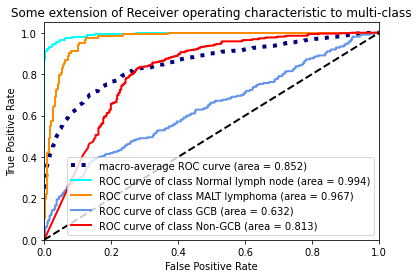

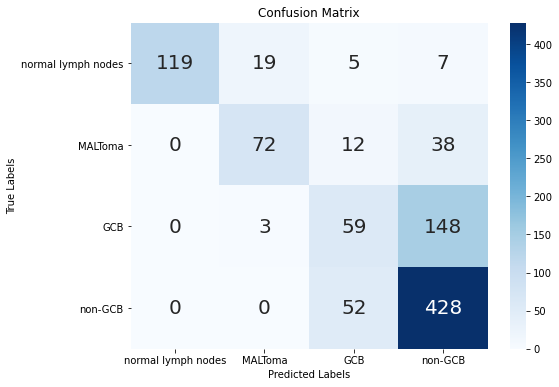

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2------------------------------------------------------------------------------
epoch:1 loss: 0.780 acc: 66.491
The current loss: 0.6214607534243294
trigger times: 0
epoch:2 loss: 0.556 acc: 76.987
The current loss: 0.4495449966542762
trigger times: 0
epoch:3 loss: 0.445 acc: 81.944
The current loss: 0.33827120257619836
trigger times: 0
epoch:4 loss: 0.360 acc: 85.156
The current loss: 0.29324535719792266
trigger times: 0
epoch:5 loss: 0.325 acc: 87.289
The current loss: 0.2514782627548648
trigger times: 0
epoch:6 loss: 0.271 acc: 89.624
The current loss: 0.22154544542159638
trigger times: 0
epoch:7 loss: 0.226 acc: 91.627
The current loss: 0.2577229411295577
trigger times: 1
epoch:8 loss: 0.203 acc: 92.523
The current loss: 0.16803404939042235
trigger times: 0
epoch:9 loss: 0.172 acc: 93.677
The current loss: 0.1252909337073699
trigger times: 0
epoch:10 loss: 0.154 acc: 94.129
The current loss: 0.07903354760299053
trigger times: 0
epoch:11 loss: 0.138 acc: 94.775
The current loss

The current loss: 0.0005146332379620833
trigger times: 0
epoch:93 loss: 0.008 acc: 99.742
The current loss: 0.00299543117189929
trigger times: 1
epoch:94 loss: 0.008 acc: 99.705
The current loss: 0.001997674952268459
trigger times: 0
epoch:95 loss: 0.008 acc: 99.742
The current loss: 0.0021973626573899
trigger times: 1
epoch:96 loss: 0.007 acc: 99.778
The current loss: 0.0007326528466291816
trigger times: 0
epoch:97 loss: 0.009 acc: 99.788
The current loss: 0.0008045714406606582
trigger times: 1
epoch:98 loss: 0.009 acc: 99.714
The current loss: 0.0006828505594227934
trigger times: 0
epoch:99 loss: 0.008 acc: 99.760
The current loss: 0.0008284760770655802
trigger times: 1
epoch:100 loss: 0.007 acc: 99.788
The current loss: 0.0014898345413479285
trigger times: 2
[[119   7  10  14]
 [  0  34  24  64]
 [  0   2  50 158]
 [  0   0  55 425]]


test accuracy : 0.653
test precison : 0.698
test recall : 0.549
test f : 0.582
AUC : 0.817
AUC for class 0: 0.997
AUC for class 1: 0.935
AUC for clas

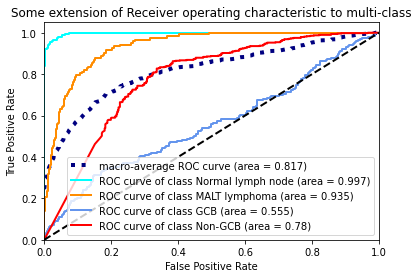

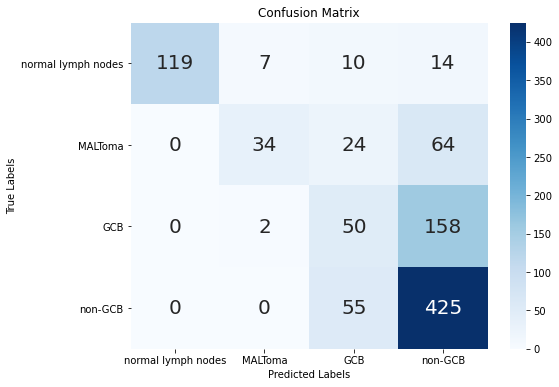

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3------------------------------------------------------------------------------
epoch:1 loss: 0.772 acc: 66.861
The current loss: 0.6961306464119339
trigger times: 0
epoch:2 loss: 0.545 acc: 77.153
The current loss: 0.45439072180083323
trigger times: 0
epoch:3 loss: 0.438 acc: 82.083
The current loss: 0.3852133680278213
trigger times: 0
epoch:4 loss: 0.368 acc: 85.138
The current loss: 0.23568712676523557
trigger times: 0
epoch:5 loss: 0.295 acc: 88.553
The current loss: 0.18997154466657956
trigger times: 0
epoch:6 loss: 0.252 acc: 90.243
The current loss: 0.2273732288953059
trigger times: 1
epoch:7 loss: 0.234 acc: 91.212
The current loss: 0.1735957645700837
trigger times: 0
epoch:8 loss: 0.200 acc: 92.449
The current loss: 0.22936210573473098
trigger times: 1
epoch:9 loss: 0.173 acc: 93.418
The current loss: 0.1432607975479472
trigger times: 0
epoch:10 loss: 0.150 acc: 94.323
The current loss: 0.2524014704677029
trigger times: 1
epoch:11 loss: 0.142 acc: 94.886
The current loss:

epoch:93 loss: 0.007 acc: 99.788
The current loss: 0.0007817220075491753
trigger times: 0
epoch:94 loss: 0.008 acc: 99.760
The current loss: 0.0009352048947236353
trigger times: 1
epoch:95 loss: 0.006 acc: 99.797
The current loss: 0.0010782892128131064
trigger times: 2
epoch:96 loss: 0.005 acc: 99.825
The current loss: 0.0006652474614415842
trigger times: 0
epoch:97 loss: 0.005 acc: 99.852
The current loss: 0.0008162164338617039
trigger times: 1
epoch:98 loss: 0.006 acc: 99.806
The current loss: 0.0007877462505568163
trigger times: 0
epoch:99 loss: 0.005 acc: 99.852
The current loss: 0.0004735067727934181
trigger times: 0
epoch:100 loss: 0.009 acc: 99.686
The current loss: 0.002839201714911157
trigger times: 1
[[115  29   2   4]
 [  0  54  15  53]
 [  0   2  60 148]
 [  0   0  56 424]]


test accuracy : 0.679
test precison : 0.690
test recall : 0.595
test f : 0.626
AUC : 0.814
AUC for class 0: 0.971
AUC for class 1: 0.946
AUC for class 2: 0.558
AUC for class 3: 0.780


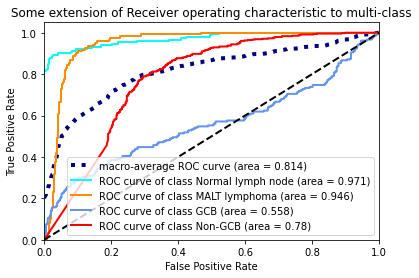

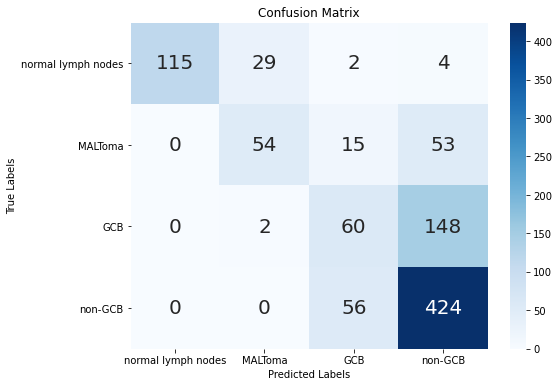

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4------------------------------------------------------------------------------
epoch:1 loss: 0.783 acc: 66.362
The current loss: 0.5898548032082946
trigger times: 0
epoch:2 loss: 0.557 acc: 76.618
The current loss: 0.4979228926496306
trigger times: 0
epoch:3 loss: 0.438 acc: 82.350
The current loss: 0.33528944881046385
trigger times: 0
epoch:4 loss: 0.356 acc: 85.175
The current loss: 0.2521587067472908
trigger times: 0
epoch:5 loss: 0.302 acc: 88.369
The current loss: 0.21971608129117753
trigger times: 0
epoch:6 loss: 0.274 acc: 89.301
The current loss: 0.3427194842959601
trigger times: 1
epoch:7 loss: 0.226 acc: 91.332
The current loss: 0.15695003648888653
trigger times: 0
epoch:8 loss: 0.198 acc: 92.181
The current loss: 0.12458985481689551
trigger times: 0
epoch:9 loss: 0.174 acc: 93.354
The current loss: 0.1406557177542065
trigger times: 1
epoch:10 loss: 0.152 acc: 94.295
The current loss: 0.18227925165061543
trigger times: 2
epoch:11 loss: 0.141 acc: 94.840
The current loss

The current loss: 0.0010681954346818945
trigger times: 1
epoch:93 loss: 0.013 acc: 99.612
The current loss: 0.0005556278328672144
trigger times: 0
epoch:94 loss: 0.006 acc: 99.825
The current loss: 0.0012362335848051158
trigger times: 1
epoch:95 loss: 0.008 acc: 99.742
The current loss: 0.0010903705724669705
trigger times: 0
epoch:96 loss: 0.005 acc: 99.852
The current loss: 0.00043947689152024956
trigger times: 0
epoch:97 loss: 0.006 acc: 99.778
The current loss: 0.0008133073308109554
trigger times: 1
epoch:98 loss: 0.007 acc: 99.769
The current loss: 0.0008134782019714945
trigger times: 2
epoch:99 loss: 0.006 acc: 99.797
The current loss: 0.0010453347961150933
trigger times: 3
epoch:100 loss: 0.003 acc: 99.954
The current loss: 0.000559687720378993
trigger times: 0
[[122  16  10   2]
 [  0  43  34  45]
 [  0   4  49 157]
 [  0   0  72 408]]


test accuracy : 0.647
test precison : 0.662
test recall : 0.562
test f : 0.593
AUC : 0.823
AUC for class 0: 0.983
AUC for class 1: 0.939
AUC fo

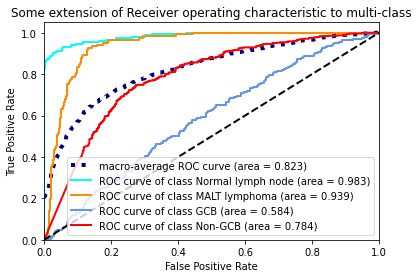

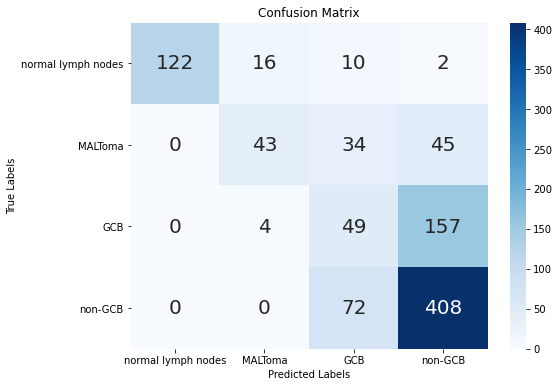

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 5------------------------------------------------------------------------------
epoch:1 loss: 0.778 acc: 67.017
The current loss: 0.5579931107408073
trigger times: 0
epoch:2 loss: 0.554 acc: 77.153
The current loss: 0.40010671242508367
trigger times: 0
epoch:3 loss: 0.431 acc: 82.793
The current loss: 0.4436783487565134
trigger times: 1
epoch:4 loss: 0.364 acc: 85.166
The current loss: 0.28161018312074915
trigger times: 0
epoch:5 loss: 0.310 acc: 87.778
The current loss: 0.19169554075416437
trigger times: 0
epoch:6 loss: 0.263 acc: 89.744
The current loss: 0.1658621367811779
trigger times: 0
epoch:7 loss: 0.234 acc: 91.083
The current loss: 0.2535438950157331
trigger times: 1
epoch:8 loss: 0.204 acc: 92.495
The current loss: 0.22881822594543305
trigger times: 0
epoch:9 loss: 0.175 acc: 93.206
The current loss: 0.17324226730378056
trigger times: 0
epoch:10 loss: 0.158 acc: 94.332
The current loss: 0.20835140877864547
trigger times: 1
epoch:11 loss: 0.146 acc: 94.729
The current los

epoch:93 loss: 0.013 acc: 99.585
The current loss: 0.002066680476557324
trigger times: 1
epoch:94 loss: 0.006 acc: 99.834
The current loss: 0.0024894578342380355
trigger times: 2
epoch:95 loss: 0.006 acc: 99.834
The current loss: 0.0009075632643185693
trigger times: 0
epoch:96 loss: 0.007 acc: 99.705
The current loss: 0.0018382015827323745
trigger times: 1
epoch:97 loss: 0.007 acc: 99.769
The current loss: 0.0005006478120151133
trigger times: 0
epoch:98 loss: 0.005 acc: 99.871
The current loss: 0.008735315721944484
trigger times: 1
epoch:99 loss: 0.006 acc: 99.825
The current loss: 0.000698913470954568
trigger times: 0
epoch:100 loss: 0.007 acc: 99.769
The current loss: 0.0009028598262225572
trigger times: 1
[[122  18   7   3]
 [  0  47  27  48]
 [  0   6  67 137]
 [  0   0  86 394]]


test accuracy : 0.655
test precison : 0.674
test recall : 0.585
test f : 0.616
AUC : 0.821
AUC for class 0: 0.996
AUC for class 1: 0.941
AUC for class 2: 0.580
AUC for class 3: 0.767


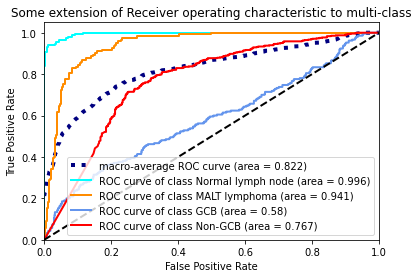

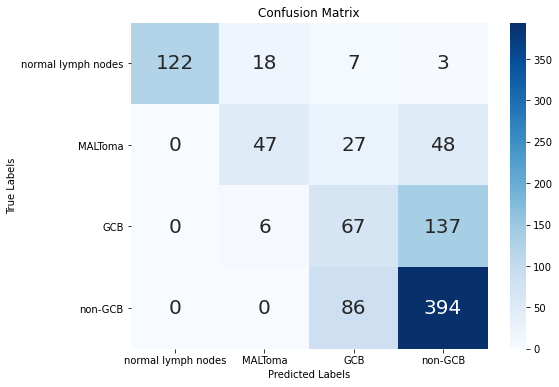

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 6------------------------------------------------------------------------------
epoch:1 loss: 0.788 acc: 66.454
The current loss: 0.7215985553541735
trigger times: 0
epoch:2 loss: 0.558 acc: 76.332
The current loss: 0.41012603146502075
trigger times: 0
epoch:3 loss: 0.431 acc: 82.295
The current loss: 0.3352680814543129
trigger times: 0
epoch:4 loss: 0.343 acc: 86.587
The current loss: 0.2641557654831795
trigger times: 0
epoch:5 loss: 0.300 acc: 88.138
The current loss: 0.345401042343073
trigger times: 1
epoch:6 loss: 0.248 acc: 90.363
The current loss: 0.15418756323727295
trigger times: 0
epoch:7 loss: 0.217 acc: 91.904
The current loss: 0.2016519317457308
trigger times: 1
epoch:8 loss: 0.185 acc: 92.901
The current loss: 0.13975299235156705
trigger times: 0
epoch:9 loss: 0.165 acc: 93.797
The current loss: 0.21438351766598845
trigger times: 1
epoch:10 loss: 0.150 acc: 94.655
The current loss: 0.11981216295720808
trigger times: 0
epoch:11 loss: 0.127 acc: 95.412
The current loss:

epoch:93 loss: 0.008 acc: 99.769
The current loss: 0.007542772127731798
trigger times: 3
epoch:94 loss: 0.008 acc: 99.732
The current loss: 0.0045116331795989045
trigger times: 0
epoch:95 loss: 0.004 acc: 99.917
The current loss: 0.0005502046774438215
trigger times: 0
epoch:96 loss: 0.005 acc: 99.862
The current loss: 0.0003530130974175123
trigger times: 0
epoch:97 loss: 0.005 acc: 99.834
The current loss: 0.0005352873512158963
trigger times: 1
epoch:98 loss: 0.003 acc: 99.926
The current loss: 0.012037627457959138
trigger times: 2
epoch:99 loss: 0.007 acc: 99.778
The current loss: 0.00040405382403110645
trigger times: 0
epoch:100 loss: 0.009 acc: 99.760
The current loss: 0.0015886370284831804
trigger times: 1
[[125  14   5   6]
 [  0  50  23  49]
 [  0   2  52 156]
 [  0   0  51 429]]


test accuracy : 0.682
test precison : 0.706
test recall : 0.596
test f : 0.628
AUC : 0.831
AUC for class 0: 0.996
AUC for class 1: 0.960
AUC for class 2: 0.576
AUC for class 3: 0.792


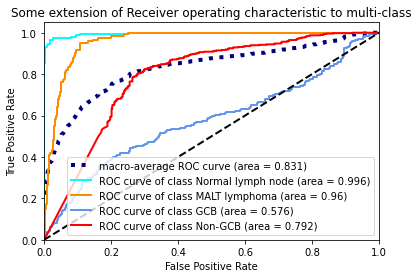

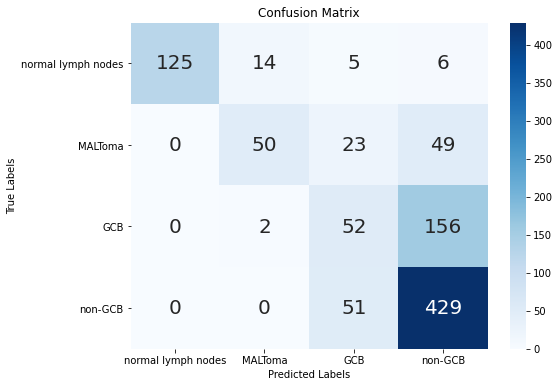

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 7------------------------------------------------------------------------------
epoch:1 loss: 0.775 acc: 66.381
The current loss: 0.6335062274041758
trigger times: 0
epoch:2 loss: 0.564 acc: 76.313
The current loss: 0.46709538236223325
trigger times: 0
epoch:3 loss: 0.440 acc: 82.138
The current loss: 0.3860713170086182
trigger times: 0
epoch:4 loss: 0.362 acc: 85.175
The current loss: 0.2785829129968124
trigger times: 0
epoch:5 loss: 0.305 acc: 88.267
The current loss: 0.27636364491856974
trigger times: 0
epoch:6 loss: 0.260 acc: 90.003
The current loss: 0.16494910251084358
trigger times: 0
epoch:7 loss: 0.225 acc: 91.332
The current loss: 0.1792379650655729
trigger times: 1
epoch:8 loss: 0.195 acc: 93.003
The current loss: 0.16976365402270405
trigger times: 0
epoch:9 loss: 0.172 acc: 93.760
The current loss: 0.22849140780911198
trigger times: 1
epoch:10 loss: 0.162 acc: 93.861
The current loss: 0.08473768153398287
trigger times: 0
epoch:11 loss: 0.143 acc: 94.729
The current los

epoch:93 loss: 0.011 acc: 99.677
The current loss: 0.0009747114109520085
trigger times: 0
epoch:94 loss: 0.009 acc: 99.658
The current loss: 0.0016647217029889239
trigger times: 1
epoch:95 loss: 0.010 acc: 99.649
The current loss: 0.010612756502330956
trigger times: 2
epoch:96 loss: 0.008 acc: 99.668
The current loss: 0.0002843924646126703
trigger times: 0
epoch:97 loss: 0.007 acc: 99.705
The current loss: 0.022943387625180056
trigger times: 1
epoch:98 loss: 0.004 acc: 99.908
The current loss: 0.0010911088030955743
trigger times: 0
epoch:99 loss: 0.007 acc: 99.778
The current loss: 0.000376439339644265
trigger times: 0
epoch:100 loss: 0.006 acc: 99.834
The current loss: 0.0017697761311970463
trigger times: 1
[[107  22   2  19]
 [  0  46  14  62]
 [  0   1  58 151]
 [  0   0  52 428]]


test accuracy : 0.664
test precison : 0.694
test recall : 0.565
test f : 0.603
AUC : 0.844
AUC for class 0: 0.991
AUC for class 1: 0.948
AUC for class 2: 0.634
AUC for class 3: 0.803


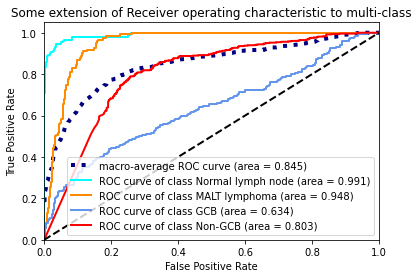

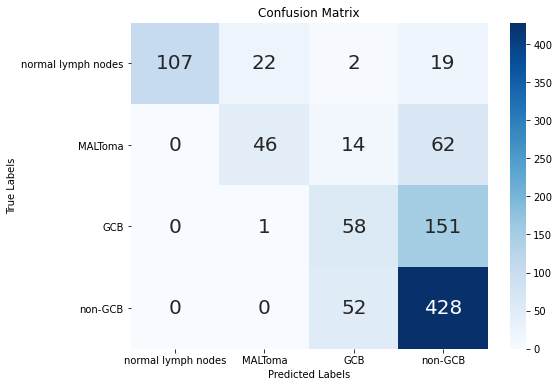

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 8------------------------------------------------------------------------------
epoch:1 loss: 0.784 acc: 66.113
The current loss: 0.5854878246957288
trigger times: 0
epoch:2 loss: 0.548 acc: 76.969
The current loss: 0.4914803984245302
trigger times: 0
epoch:3 loss: 0.423 acc: 82.830
The current loss: 0.3920438850788224
trigger times: 0
epoch:4 loss: 0.359 acc: 85.756
The current loss: 0.24809932666331488
trigger times: 0
epoch:5 loss: 0.295 acc: 88.664
The current loss: 0.20098718767101426
trigger times: 0
epoch:6 loss: 0.253 acc: 90.261
The current loss: 0.24977037007382796
trigger times: 1
epoch:7 loss: 0.212 acc: 91.877
The current loss: 0.4015354150876157
trigger times: 2
epoch:8 loss: 0.192 acc: 92.551
The current loss: 0.10797834348431129
trigger times: 0
epoch:9 loss: 0.169 acc: 93.584
The current loss: 0.86737118951985
trigger times: 1
epoch:10 loss: 0.147 acc: 94.471
The current loss: 0.4707649839144584
trigger times: 0
epoch:11 loss: 0.136 acc: 94.886
The current loss: 0

epoch:93 loss: 0.006 acc: 99.788
The current loss: 0.0012134384999232318
trigger times: 1
epoch:94 loss: 0.006 acc: 99.825
The current loss: 0.0027639243184230168
trigger times: 2
epoch:95 loss: 0.007 acc: 99.788
The current loss: 0.0003657954219841095
trigger times: 0
epoch:96 loss: 0.006 acc: 99.843
The current loss: 0.00038058794795926425
trigger times: 1
epoch:97 loss: 0.007 acc: 99.742
The current loss: 0.0018788515662245685
trigger times: 2
epoch:98 loss: 0.006 acc: 99.788
The current loss: 0.05215617877539827
trigger times: 3
epoch:99 loss: 0.006 acc: 99.898
The current loss: 0.0009031658880926712
trigger times: 0
epoch:100 loss: 0.005 acc: 99.871
The current loss: 0.0010624530633938836
trigger times: 1
[[101  16   6  27]
 [  0  56  16  50]
 [  0   2  59 149]
 [  0   0  50 430]]


test accuracy : 0.672
test precison : 0.716
test recall : 0.577
test f : 0.620
AUC : 0.832
AUC for class 0: 0.986
AUC for class 1: 0.961
AUC for class 2: 0.599
AUC for class 3: 0.780


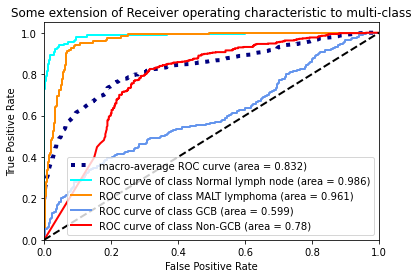

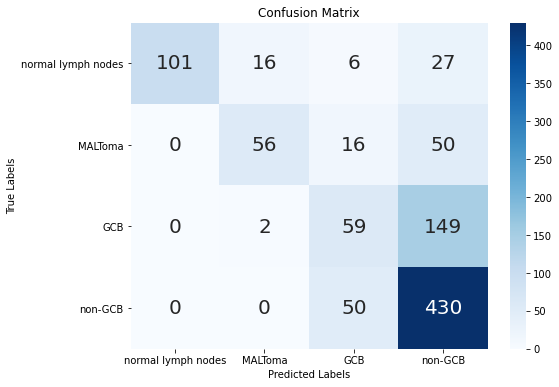

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 9------------------------------------------------------------------------------
epoch:1 loss: 0.776 acc: 66.907
The current loss: 0.6382021554416062
trigger times: 0
epoch:2 loss: 0.546 acc: 77.079
The current loss: 0.47459440560603466
trigger times: 0
epoch:3 loss: 0.433 acc: 82.830
The current loss: 0.3880005091289934
trigger times: 0
epoch:4 loss: 0.368 acc: 85.406
The current loss: 0.32924094928113795
trigger times: 0
epoch:5 loss: 0.315 acc: 87.750
The current loss: 0.259117509725353
trigger times: 0
epoch:6 loss: 0.270 acc: 89.458
The current loss: 0.21440689273385996
trigger times: 0
epoch:7 loss: 0.231 acc: 91.203
The current loss: 0.17565393174581134
trigger times: 0
epoch:8 loss: 0.204 acc: 92.218
The current loss: 0.1909582156587453
trigger times: 1
epoch:9 loss: 0.198 acc: 92.569
The current loss: 0.4381843089180738
trigger times: 2
epoch:10 loss: 0.158 acc: 94.332
The current loss: 0.1300386978003224
trigger times: 0
epoch:11 loss: 0.136 acc: 94.877
The current loss: 

epoch:93 loss: 0.010 acc: 99.649
The current loss: 0.013518448920654666
trigger times: 1
epoch:94 loss: 0.007 acc: 99.797
The current loss: 0.0010824360509992697
trigger times: 0
epoch:95 loss: 0.008 acc: 99.732
The current loss: 0.0018082210325535584
trigger times: 1
epoch:96 loss: 0.009 acc: 99.760
The current loss: 0.015024421428011893
trigger times: 2
epoch:97 loss: 0.009 acc: 99.723
The current loss: 0.008485077199289162
trigger times: 0
epoch:98 loss: 0.008 acc: 99.788
The current loss: 0.0006598992561522071
trigger times: 0
epoch:99 loss: 0.010 acc: 99.695
The current loss: 0.0009360987616137177
trigger times: 1
epoch:100 loss: 0.006 acc: 99.788
The current loss: 0.0009397308807693224
trigger times: 2
[[107  24   3  16]
 [  0  68  25  29]
 [  0   9  41 160]
 [  0   0  72 408]]


test accuracy : 0.649
test precison : 0.657
test recall : 0.579
test f : 0.606
AUC : 0.818
AUC for class 0: 0.992
AUC for class 1: 0.957
AUC for class 2: 0.547
AUC for class 3: 0.775


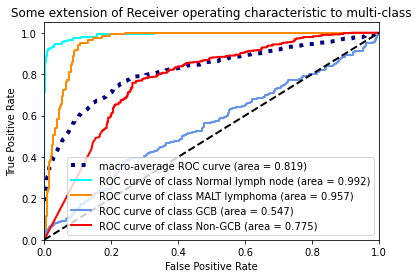

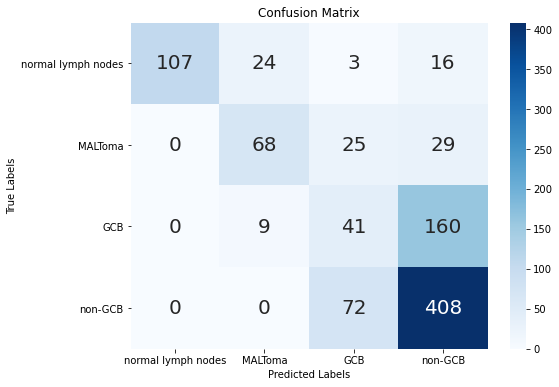

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 10------------------------------------------------------------------------------
epoch:1 loss: 0.773 acc: 67.082
The current loss: 0.6315863342463949
trigger times: 0
epoch:2 loss: 0.537 acc: 77.781
The current loss: 0.39644476303907666
trigger times: 0
epoch:3 loss: 0.418 acc: 83.292
The current loss: 0.35875218679526116
trigger times: 0
epoch:4 loss: 0.353 acc: 86.153
The current loss: 0.2607584392537217
trigger times: 0
epoch:5 loss: 0.295 acc: 88.535
The current loss: 0.18633589598926809
trigger times: 0
epoch:6 loss: 0.255 acc: 90.418
The current loss: 0.33281416271931347
trigger times: 1
epoch:7 loss: 0.223 acc: 91.646
The current loss: 0.19249997425048174
trigger times: 0
epoch:8 loss: 0.192 acc: 92.818
The current loss: 0.19740318566779924
trigger times: 1
epoch:9 loss: 0.181 acc: 93.243
The current loss: 0.1784493359749547
trigger times: 0
epoch:10 loss: 0.155 acc: 94.184
The current loss: 0.2335360265733095
trigger times: 1
epoch:11 loss: 0.137 acc: 94.997
The current lo

epoch:93 loss: 0.008 acc: 99.769
The current loss: 0.0007693810729429951
trigger times: 0
epoch:94 loss: 0.007 acc: 99.778
The current loss: 0.0005592739040370179
trigger times: 0
epoch:95 loss: 0.009 acc: 99.714
The current loss: 0.002484180761981327
trigger times: 1
epoch:96 loss: 0.012 acc: 99.649
The current loss: 0.0017785400644562805
trigger times: 0
epoch:97 loss: 0.008 acc: 99.714
The current loss: 0.001262073129504128
trigger times: 0
epoch:98 loss: 0.012 acc: 99.612
The current loss: 0.003991886764933916
trigger times: 1
epoch:99 loss: 0.006 acc: 99.760
The current loss: 0.0008477529618156806
trigger times: 0
epoch:100 loss: 0.006 acc: 99.834
The current loss: 0.012235712249458953
trigger times: 1
[[121  15  13   1]
 [  0  60  44  18]
 [  1   3  44 162]
 [  0   0  93 387]]


test accuracy : 0.636
test precison : 0.667
test recall : 0.579
test f : 0.612
AUC : 0.813
AUC for class 0: 0.993
AUC for class 1: 0.948
AUC for class 2: 0.535
AUC for class 3: 0.778


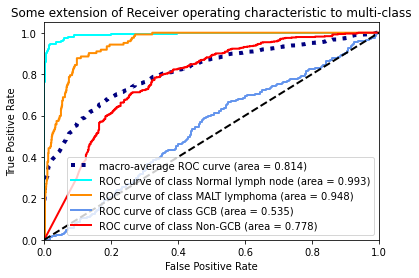

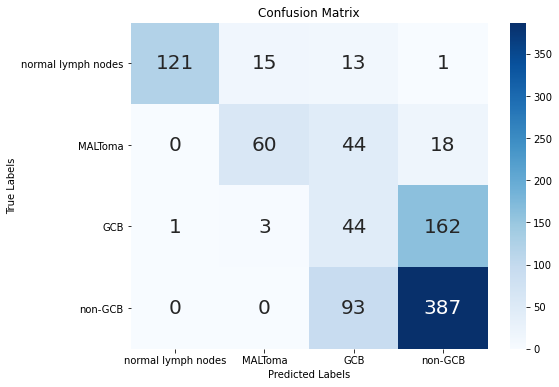

CPU times: user 7d 21h 39min 48s, sys: 28min 2s, total: 7d 22h 7min 50s
Wall time: 1d 1h 8min 51s


In [9]:
%%time

def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # ResNet18 のロード
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        # 最終層を4クラスの出力に変更
        model.fc = nn.Linear(num_ftrs, 4)
        
        for param in model.parameters():
            param.requires_grad = True  # Set to True for fine-tuning
        model = model.to(device)

        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        # Pass all model parameters to the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # Optimize the entire model for fine-tuning
        
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()